In [1]:
import pandas as pd
import numpy as np 
import pypsa

ERROR 1: PROJ: proj_create_from_database: Open of /trinity/home/thomgeo/micromamba/envs/lmp-v13/share/proj failed


In [2]:
from pypsa.descriptors import get_switchable_as_dense as as_dense

## Notes

- remove e_initial from h

In [3]:
n = pypsa.examples.scigrid_de()

INFO:pypsa.io:Imported network scigrid-de.nc has buses, generators, lines, loads, storage_units, transformers


In [4]:
def replace_su(network, su_to_replace):

    su = network.storage_units.loc[su_to_replace]

    bus_name = "{} {}".format(su["bus"], su["carrier"])
    link_1_name = "{} converter {} to AC".format(su_to_replace, su["carrier"])
    link_2_name = "{} converter AC to {}".format(su_to_replace, su["carrier"])
    store_name = "{} store {}".format(su_to_replace, su["carrier"])
    gen_name = "{} inflow".format(su_to_replace)

    if bus_name not in network.buses.index:
        network.add("Bus", bus_name, carrier=su["carrier"])

    # dispatch link
    network.add(
        "Link",
        link_1_name,
        bus0=bus_name,
        bus1=su["bus"],
        capital_cost=su["capital_cost"] * su["efficiency_dispatch"],
        p_nom=su["p_nom"] / su["efficiency_dispatch"],
        p_nom_extendable=su["p_nom_extendable"],
        p_nom_max=su["p_nom_max"] / su["efficiency_dispatch"],
        p_nom_min=su["p_nom_min"] / su["efficiency_dispatch"],
        p_max_pu=su["p_max_pu"],
        marginal_cost=su["marginal_cost"] * su["efficiency_dispatch"],
        efficiency=su["efficiency_dispatch"],
        carrier = su["carrier"],
        type="discharging",
    )

    # store link
    network.add(
        "Link",
        link_2_name,
        bus1=bus_name,
        bus0=su["bus"],
        p_nom=su["p_nom"],
        p_nom_extendable=su["p_nom_extendable"],
        p_nom_max=su["p_nom_max"],
        p_nom_min=su["p_nom_min"],
        p_max_pu=-su["p_min_pu"],
        efficiency=su["efficiency_store"],
        carrier = su["carrier"],
        type="charging"
    )

    if (
        su_to_replace in network.storage_units_t.state_of_charge_set.columns
        and (
            ~pd.isnull(network.storage_units_t.state_of_charge_set[su_to_replace])
        ).any()
    ):
        e_max_pu = pd.Series(data=1.0, index=network.snapshots)
        e_min_pu = pd.Series(data=0.0, index=network.snapshots)
        non_null = ~pd.isnull(
            network.storage_units_t.state_of_charge_set[su_to_replace]
        )
        e_max_pu[non_null] = network.storage_units_t.state_of_charge_set[su_to_replace][
            non_null
        ]
        e_min_pu[non_null] = network.storage_units_t.state_of_charge_set[su_to_replace][
            non_null
        ]
    else:
        e_max_pu = 1.0
        e_min_pu = 0.0

    network.add(
        "Store",
        store_name,
        bus=bus_name,
        e_nom=su["p_nom"] * su["max_hours"],
        e_nom_min=su["p_nom_min"] / su["efficiency_dispatch"] * su["max_hours"],
        e_nom_max=su["p_nom_max"] / su["efficiency_dispatch"] * su["max_hours"],
        e_nom_extendable=su["p_nom_extendable"],
        e_max_pu=e_max_pu,
        e_min_pu=e_min_pu,
        standing_loss=su["standing_loss"],
        e_cyclic=su["cyclic_state_of_charge"],
        e_initial=su["state_of_charge_initial"],
        carrier = su["carrier"]
    )


    # inflow from a variable generator, which can be curtailed (i.e. spilled)
    inflow_max = as_dense(network, "StorageUnit", "inflow").max()[su_to_replace]
    
    if inflow_max == 0.0:
        inflow_pu = 0.0
    else:
        inflow_pu = network.storage_units_t.inflow[su_to_replace] / inflow_max

    if inflow_max >0:
        network.add(
            "Generator",
            gen_name,
            bus=bus_name,
            carrier="rain",
            p_nom=inflow_max,
            p_max_pu=inflow_pu,
        )
        
    network.add(
        "Generator",
        gen_name + " loss-of-charge",
        bus=bus_name,
        carrier= su["carrier"],
        p_nom=su["p_nom"] * su["max_hours"],
        marginal_cost = 200,
        type="inflow",
        )

    network.remove("StorageUnit", su_to_replace)

In [5]:
for su in n.storage_units.index:
    replace_su(n, su);

In [6]:
n_opt = n.copy()

In [8]:
n_opt.optimize(solver_name="cplex")

Index(['2', '5', '10', '12', '13', '15', '18', '20', '22', '24', '26', '30',
       '32', '37', '42', '46', '52', '56', '61', '68', '69', '74', '78', '86',
       '87', '94', '95', '96', '99', '100', '104', '105', '106', '107', '117',
       '120', '123', '124', '125', '128', '129', '138', '143', '156', '157',
       '159', '160', '165', '184', '191', '195', '201', '220', '231', '232',
       '233', '236', '247', '248', '250', '251', '252', '261', '263', '264',
       '267', '272', '279', '281', '282', '292', '303', '307', '308', '312',
       '315', '317', '322', '332', '334', '336', '338', '351', '353', '360',
       '362', '382', '384', '385', '391', '403', '404', '413', '421', '450',
       '458'],
      dtype='object', name='Transformer')
Index(['2', '5', '10', '12', '13', '15', '18', '20', '22', '24', '26', '30',
       '32', '37', '42', '46', '52', '56', '61', '68', '69', '74', '78', '86',
       '87', '94', '95', '96', '99', '100', '104', '105', '106', '107', '117',
       '120

Checking license ...


cpxchecklic: /lib64/libcurl.so.4: no version information available (required by cpxchecklic)



License found. [0.02 s]
Version identifier: 22.1.1.0 | 2023-06-15 | d64d5bd77
CPXPARAM_Read_DataCheck                          1
Parallel mode: deterministic, using up to 32 threads for concurrent optimization:
 * Starting dual Simplex on 1 thread...
 * Starting Barrier on 30 threads...
 * Starting primal Simplex on 1 thread...
Tried aggregator 1 time.
LP Presolve eliminated 121182 rows and 16948 columns.
Aggregator did 10025 substitutions.
Reduced LP has 14497 rows, 34491 columns, and 98769 nonzeros.
Presolve time = 0.18 sec. (95.42 ticks)

Iteration log . . .
Iteration:     1   Dual objective     =         37603.389805
Perturbation started.
Iteration:   101   Dual objective     =         37603.389805
Iteration:   539   Dual objective     =         37604.123311
Iteration:   998   Dual objective     =         37604.644476
Iteration:  1529   Dual objective     =         37605.158327
Iteration:  2032   Dual objective     =         37605.600014
Iteration:  2486   Dual objective     =     

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 61464 primals, 145704 duals
Objective: 6.68e+06
Solver model: available
Solver message: optimal

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Line-fix-s-lower, Line-fix-s-upper, Transformer-fix-s-lower, Transformer-fix-s-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Kirchhoff-Voltage-Law, Store-energy_balance were not assigned to the network.


('ok', 'optimal')

In [9]:
n_opt.objective

6684817.323606998

In [10]:
n1 = n.copy()
n1.set_snapshots(n.snapshots[:12])

n2 = n.copy()
n2.set_snapshots(n.snapshots[12:])

In [11]:
def optimality_cut_parameters(n):

    m = n.model
    
    h_gen = {}
    u_gen = {}

    for c in m.constraints:
        
        constraint = m.constraints[c]

        h_constraint = constraint.rhs.to_dataframe()
        h_gen[c] = h_constraint

        u_constraint = m.constraints[c].dual.to_dataframe()
        u_gen[c] =  u_constraint

    return h_gen, u_gen

In [13]:
n1.optimize.create_model()


theta = n1.model.add_variables(lower=-1e6, name="theta")

obj = n1.model.objective.expression
n1.model.add_objective(obj + theta, overwrite=True)

Index(['2', '5', '10', '12', '13', '15', '18', '20', '22', '24', '26', '30',
       '32', '37', '42', '46', '52', '56', '61', '68', '69', '74', '78', '86',
       '87', '94', '95', '96', '99', '100', '104', '105', '106', '107', '117',
       '120', '123', '124', '125', '128', '129', '138', '143', '156', '157',
       '159', '160', '165', '184', '191', '195', '201', '220', '231', '232',
       '233', '236', '247', '248', '250', '251', '252', '261', '263', '264',
       '267', '272', '279', '281', '282', '292', '303', '307', '308', '312',
       '315', '317', '322', '332', '334', '336', '338', '351', '353', '360',
       '362', '382', '384', '385', '391', '403', '404', '413', '421', '450',
       '458'],
      dtype='object', name='Transformer')


In [14]:
i = 0

In [15]:
while i < 10:
    
    print("\n\nStarting with iteration " + str(i) + "\n\n")

    n1.optimize.solve_model(solver_name="cbc")

    n2.stores.e_initial = n1.stores_t.e.iloc[-1]

    n2.optimize(solver_name="cbc")

    h_p, u_p = optimality_cut_parameters(n2)

    h_p["Store-energy_balance"].loc[n2.snapshots[0], "rhs"] = 0

    T_p = pd.DataFrame(0, h_p['Store-energy_balance'].index, n2.stores.index)

    for store in n2.stores.index:
        T_p.loc[(n2.snapshots[0], store), store] = 1

    E_p = T_p.multiply(u_p["Store-energy_balance"].dual, axis=0).sum()

    e_p = sum(u_p[c].dual.multiply(h_p[c].rhs).sum() for c in n2.model.constraints)

    store_e = n1.model["Store-e"]

    n1.model.add_constraints(
        (
            store_e.loc[n1.snapshots[-1]]
            *E_p.to_xarray()
        ).sum()
        + n1.model.variables.theta >= e_p
    )
    
    if n1.model.solution.theta.to_dict()["data"] >= n2.objective:
        break
    
    i+=1

INFO:linopy.model: Solve problem using Cbc solver




Starting with iteration 0




AssertionError: Solver cbc not installed

<AxesSubplot:xlabel='Store'>

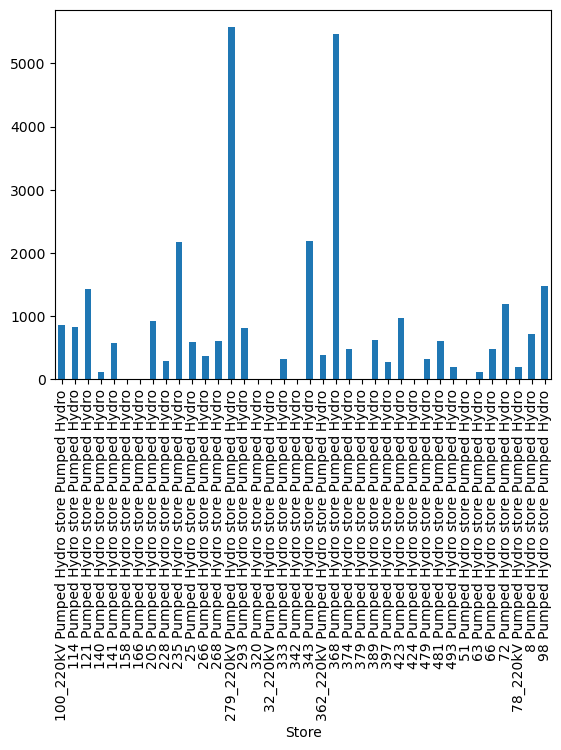

In [33]:
n2.stores.e_initial.plot.bar()

<AxesSubplot:xlabel='Store'>

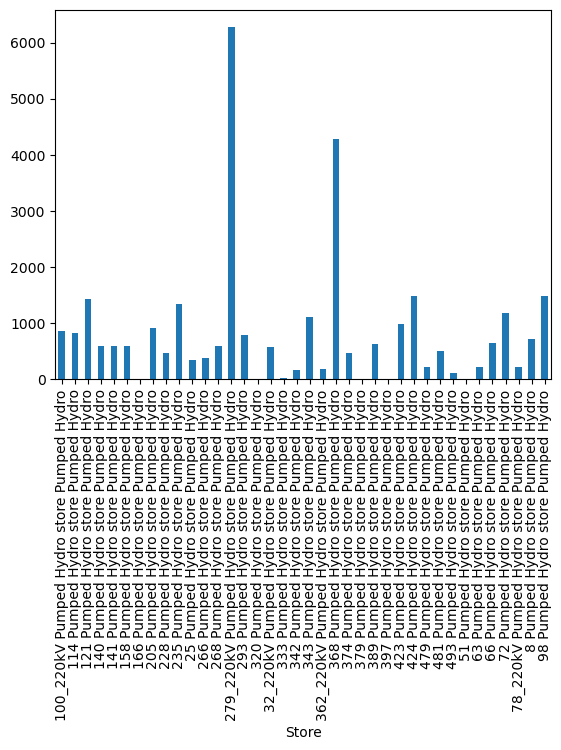

In [15]:
n1.optimize(
    solver_name="cbc", 
    extra_functionality=add_theta
)

Index(['2', '5', '10', '12', '13', '15', '18', '20', '22', '24', '26', '30',
       '32', '37', '42', '46', '52', '56', '61', '68', '69', '74', '78', '86',
       '87', '94', '95', '96', '99', '100', '104', '105', '106', '107', '117',
       '120', '123', '124', '125', '128', '129', '138', '143', '156', '157',
       '159', '160', '165', '184', '191', '195', '201', '220', '231', '232',
       '233', '236', '247', '248', '250', '251', '252', '261', '263', '264',
       '267', '272', '279', '281', '282', '292', '303', '307', '308', '312',
       '315', '317', '322', '332', '334', '336', '338', '351', '353', '360',
       '362', '382', '384', '385', '391', '403', '404', '413', '421', '450',
       '458'],
      dtype='object', name='Transformer')
Index(['2', '5', '10', '12', '13', '15', '18', '20', '22', '24', '26', '30',
       '32', '37', '42', '46', '52', '56', '61', '68', '69', '74', '78', '86',
       '87', '94', '95', '96', '99', '100', '104', '105', '106', '107', '117',
       '120

Welcome to the CBC MILP Solver 
Version: 2.10.10 
Build Date: Apr 19 2023 

command line - cbc -printingOptions all -import /tmp/linopy-problem-yukou5k9.lp -solve -solu /tmp/linopy-solve-3hgv00av.sol (default strategy 1)
Option for printingOptions changed from normal to all
Presolve 7294 (-65558) rows, 13713 (-17020) columns and 45881 (-87029) elements
Perturbing problem by 0.001% of 2155.1063 - largest nonzero change 0.00099885507 ( 0.04638933%) - largest zero change 0.00099882928
0  Obj -9902183.8 Primal inf 23792309 (6680) Dual inf 375.24321 (4)
220  Obj -9996211.8 Primal inf 17434132 (6639)
440  Obj -9996210.4 Primal inf 15726518 (6541)
660  Obj -9996209.5 Primal inf 15135100 (6484)
880  Obj -9996209.2 Primal inf 14419221 (6392)
1100  Obj -9996208.4 Primal inf 14310985 (6336)
1320  Obj -9996207.3 Primal inf 13268956 (6230)
1540  Obj -9996205.9 Primal inf 13067803 (6133)
1760  Obj -9996205.4 Primal inf 12334628 (6024)
1980  Obj -9996204.6 Primal inf 12887216 (5991)
2200  Obj -999620

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Line-fix-s-lower, Line-fix-s-upper, Transformer-fix-s-lower, Transformer-fix-s-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Kirchhoff-Voltage-Law, Store-energy_balance were not assigned to the network.


('ok', 'optimal')

In [114]:
n2.stores.e_initial = n1.stores_t.e.iloc[-1]

In [115]:
n2.optimize(
    solver_name="cbc", 
    #extra_functionality=add_theta
)

Index(['2', '5', '10', '12', '13', '15', '18', '20', '22', '24', '26', '30',
       '32', '37', '42', '46', '52', '56', '61', '68', '69', '74', '78', '86',
       '87', '94', '95', '96', '99', '100', '104', '105', '106', '107', '117',
       '120', '123', '124', '125', '128', '129', '138', '143', '156', '157',
       '159', '160', '165', '184', '191', '195', '201', '220', '231', '232',
       '233', '236', '247', '248', '250', '251', '252', '261', '263', '264',
       '267', '272', '279', '281', '282', '292', '303', '307', '308', '312',
       '315', '317', '322', '332', '334', '336', '338', '351', '353', '360',
       '362', '382', '384', '385', '391', '403', '404', '413', '421', '450',
       '458'],
      dtype='object', name='Transformer')
Index(['2', '5', '10', '12', '13', '15', '18', '20', '22', '24', '26', '30',
       '32', '37', '42', '46', '52', '56', '61', '68', '69', '74', '78', '86',
       '87', '94', '95', '96', '99', '100', '104', '105', '106', '107', '117',
       '120

Welcome to the CBC MILP Solver 
Version: 2.10.10 
Build Date: Apr 19 2023 

command line - cbc -printingOptions all -import /tmp/linopy-problem-1gn0d4yz.lp -solve -solu /tmp/linopy-solve-d99g_q4t.sol (default strategy 1)
Option for printingOptions changed from normal to all
Presolve 7333 (-65519) rows, 13806 (-16926) columns and 46091 (-86819) elements
Perturbing problem by 0.001% of 6864.1841 - largest nonzero change 0.00099766078 ( 0.0031661008%) - largest zero change 0.00099761978
0  Obj 186427.8 Primal inf 25074855 (6824) Dual inf 2640.3198 (7)
221  Obj 33325.832 Primal inf 17968976 (6753)
442  Obj 33326.537 Primal inf 15555408 (6613)
663  Obj 33327.408 Primal inf 14817041 (6577)
884  Obj 33328.368 Primal inf 15068869 (6503)
1105  Obj 33328.44 Primal inf 14390178 (6395)
1326  Obj 33328.606 Primal inf 14848293 (6331)
1547  Obj 33329.266 Primal inf 12487884 (6192)
1768  Obj 33329.664 Primal inf 13052672 (6110)
1989  Obj 33330.042 Primal inf 17840379 (6051)
2210  Obj 33332.283 Primal 

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Line-fix-s-lower, Line-fix-s-upper, Transformer-fix-s-lower, Transformer-fix-s-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Kirchhoff-Voltage-Law, Store-energy_balance were not assigned to the network.


('ok', 'optimal')

In [116]:
E = ((n2.stores.e_initial>=0)*1).multiply(
    n2.model.constraints["Store-energy_balance"].dual.to_dataframe().loc[n2.snapshots[0]].dual
)

In [130]:
E - (n1.stores_t.e.iloc[-1]*e)

Store
100_220kV Pumped Hydro store Pumped Hydro    2.241135e+01
114 Pumped Hydro store Pumped Hydro          2.047375e+01
121 Pumped Hydro store Pumped Hydro          2.225975e+01
140 Pumped Hydro store Pumped Hydro          1.858242e+01
141 Pumped Hydro store Pumped Hydro          1.862678e+01
158 Pumped Hydro store Pumped Hydro          2.225975e+01
166 Pumped Hydro store Pumped Hydro          1.895570e+01
205 Pumped Hydro store Pumped Hydro          1.962209e+01
228 Pumped Hydro store Pumped Hydro          2.090000e+01
235 Pumped Hydro store Pumped Hydro          2.170587e+01
25 Pumped Hydro store Pumped Hydro          -5.600924e+09
266 Pumped Hydro store Pumped Hydro          2.148707e+01
268 Pumped Hydro store Pumped Hydro          2.669893e+01
279_220kV Pumped Hydro store Pumped Hydro    2.112494e+01
293 Pumped Hydro store Pumped Hydro          2.136707e+01
320 Pumped Hydro store Pumped Hydro          2.550831e+01
32_220kV Pumped Hydro store Pumped Hydro     2.079828e+01
333 Pump

In [117]:
def determine_e(n):
    m = n.model

    h_gen = pd.DataFrame()
    u_gen = pd.DataFrame()

    for c in m.constraints:
        constraint = m.constraints[c]

        h_constraint = constraint.rhs.to_dataframe()

        if c == 'Store-energy_balance':
            h_constraint.loc[n.snapshots[0], "rhs"] = 0

        h_constraint = h_constraint.set_index(
            pd.Series(c, index=h_constraint.index, name="constraint"),
            append=True
        ).reorder_levels(["constraint"] + h_constraint.index.names)

        h_constraint.index = h_constraint.index.to_flat_index()

        h_gen = pd.concat([h_gen, h_constraint])

        u_constraint = m.constraints[c].dual.to_dataframe()

        u_constraint = u_constraint.set_index(
            pd.Series(c, index=u_constraint.index, name="constraint"),
            append=True
        ).reorder_levels(["constraint"] + u_constraint.index.names)

        u_constraint.index = u_constraint.index.to_flat_index()

        u_gen = pd.concat([u_gen, u_constraint])
    
    return h_gen, u_gen
    

In [118]:
h, u = determine_e(n2)

In [119]:
e = h.rhs.multiply(u.dual).sum()

In [120]:
e

4762690.552731366

In [121]:
m = n1.model

In [122]:
i += 1

In [123]:
m.add_constraints(
    (m.variables["Store-e"].loc[n1.snapshots[-1]]*E.to_xarray()).sum() + m.variables.theta >= e,
    name="Optimality cut " + str(i)
)

Constraint `Optimality cut 8`
-----------------------------
+22.41 Store-e[2011-01-01 11:00:00, 100_220kV Pumped Hydro store Pumped Hydro] + 20.47 Store-e[2011-01-01 11:00:00, 114 Pumped Hydro store Pumped Hydro] + 22.26 Store-e[2011-01-01 11:00:00, 121 Pumped Hydro store Pumped Hydro] ... +18.61 Store-e[2011-01-01 11:00:00, 8 Pumped Hydro store Pumped Hydro] + 19.53 Store-e[2011-01-01 11:00:00, 98 Pumped Hydro store Pumped Hydro] + 1 theta ≥ 4762690.552731366

In [124]:
n1.optimize.solve_model(solver_name="cbc")

INFO:linopy.model: Solve problem using Cbc solver
INFO:linopy.io:Writing objective.
Writing constraints.: 100% 21/21 [00:00<00:00, 50.05it/s]
Writing continuous variables.: 100% 7/7 [00:00<00:00, 101.12it/s]
INFO:linopy.io: Writing time: 0.51s


Welcome to the CBC MILP Solver 
Version: 2.10.10 
Build Date: Apr 19 2023 

command line - cbc -printingOptions all -import /tmp/linopy-problem-daodmtfl.lp -solve -solu /tmp/linopy-solve-bogcmqwh.sol (default strategy 1)
Option for printingOptions changed from normal to all
Presolve 7302 (-65558) rows, 13740 (-16993) columns and 46209 (-87004) elements
Perturbing problem by 0.001% of 3016.5068 - largest nonzero change 0.0009978036 ( 0.016591658%) - largest zero change 0.00099744634
0  Obj 4849548.8 Primal inf 23803938 (6688) Dual inf 375.2432 (4)
221  Obj 4755520.7 Primal inf 17429749 (6650)
442  Obj 4755522.5 Primal inf 15816496 (6546)
663  Obj 4755523.6 Primal inf 15536938 (6501)
884  Obj 4755524.3 Primal inf 14626241 (6437)
1105  Obj 4755525.4 Primal inf 14337400 (6381)
1326  Obj 4755526.2 Primal inf 12905740 (6258)
1547  Obj 4755526.3 Primal inf 14373373 (6181)
1768  Obj 4755527.9 Primal inf 12550703 (6076)
1989  Obj 4755529.4 Primal inf 13507221 (6020)
2210  Obj 4755530.9 Primal i

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 30733 primals, 72860 duals
Objective: 6.87e+06
Solver model: not available
Solver message: Optimal - objective value 6872356.16954819


INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Line-fix-s-lower, Line-fix-s-upper, Transformer-fix-s-lower, Transformer-fix-s-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Kirchhoff-Voltage-Law, Store-energy_balance, Optimality cut 1, Optimality cut 2, Optimality cut 3, Optimality cut 4, Optimality cut 5, Optimality cut 6, Optimality cut 7, Optimality cut 8 were not assigned to the network.


('ok', 'optimal')

In [125]:
n1.stores_t.e.iloc[-1]

Store
100_220kV Pumped Hydro store Pumped Hydro       0.00000
114 Pumped Hydro store Pumped Hydro             0.00000
121 Pumped Hydro store Pumped Hydro             0.00000
140 Pumped Hydro store Pumped Hydro             0.00000
141 Pumped Hydro store Pumped Hydro             0.00000
158 Pumped Hydro store Pumped Hydro             0.00000
166 Pumped Hydro store Pumped Hydro             0.00000
205 Pumped Hydro store Pumped Hydro             0.00000
228 Pumped Hydro store Pumped Hydro             0.00000
235 Pumped Hydro store Pumped Hydro             0.00000
25 Pumped Hydro store Pumped Hydro           1176.00000
266 Pumped Hydro store Pumped Hydro             0.00000
268 Pumped Hydro store Pumped Hydro             0.00000
279_220kV Pumped Hydro store Pumped Hydro       0.00000
293 Pumped Hydro store Pumped Hydro             0.00000
320 Pumped Hydro store Pumped Hydro             0.00000
32_220kV Pumped Hydro store Pumped Hydro        0.00000
333 Pumped Hydro store Pumped Hydro       

In [126]:
n2.stores.e_initial

Store
100_220kV Pumped Hydro store Pumped Hydro       0.00000
114 Pumped Hydro store Pumped Hydro             0.00000
121 Pumped Hydro store Pumped Hydro             0.00000
140 Pumped Hydro store Pumped Hydro             0.00000
141 Pumped Hydro store Pumped Hydro             0.00000
158 Pumped Hydro store Pumped Hydro             0.00000
166 Pumped Hydro store Pumped Hydro             0.00000
205 Pumped Hydro store Pumped Hydro             0.00000
228 Pumped Hydro store Pumped Hydro             0.00000
235 Pumped Hydro store Pumped Hydro             0.00000
25 Pumped Hydro store Pumped Hydro           1176.00000
266 Pumped Hydro store Pumped Hydro             0.00000
268 Pumped Hydro store Pumped Hydro             0.00000
279_220kV Pumped Hydro store Pumped Hydro       0.00000
293 Pumped Hydro store Pumped Hydro             0.00000
320 Pumped Hydro store Pumped Hydro             0.00000
32_220kV Pumped Hydro store Pumped Hydro        0.00000
333 Pumped Hydro store Pumped Hydro       

In [208]:
m.solve(

    solver_name="cbc"
)

INFO:linopy.model: Solve problem using Cbc solver
INFO:linopy.io:Writing objective.
Writing constraints.: 100% 19/19 [00:00<00:00, 49.29it/s]
Writing continuous variables.: 100% 7/7 [00:00<00:00, 108.94it/s]
INFO:linopy.io: Writing time: 0.47s
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 30733 primals, 72858 duals
Objective: 6.88e+06
Solver model: not available
Solver message: Optimal - objective value 6876782.71731035




Welcome to the CBC MILP Solver 
Version: 2.10.10 
Build Date: Apr 19 2023 

command line - cbc -printingOptions all -import /tmp/linopy-problem-bpk5z6hg.lp -solve -solu /tmp/linopy-solve-nb04no2q.sol (default strategy 1)
Option for printingOptions changed from normal to all
Presolve 7296 (-65562) rows, 13715 (-17018) columns and 45890 (-87044) elements
Perturbing problem by 0.001% of 2155.1063 - largest nonzero change 0.00099997287 ( 0.036530155%) - largest zero change 0.00099940831
0  Obj 2975536.5 Primal inf 23807702 (6682) Dual inf 375.24321 (4)
220  Obj 2881508.5 Primal inf 17424848 (6646)
440  Obj 2881510.1 Primal inf 23180559 (6555)
660  Obj 2881511.1 Primal inf 15209723 (6482)
880  Obj 2881511.4 Primal inf 14202441 (6393)
1100  Obj 4766640 Primal inf 13920810 (6313)
1320  Obj 4766640 Primal inf 13046453 (6232)
1540  Obj 4766641 Primal inf 13437548 (6192)
1760  Obj 4766641.6 Primal inf 13212476 (6052)
1980  Obj 4766642.5 Primal inf 13009651 (5999)
2200  Obj 4766644.1 Primal inf 1

('ok', 'optimal')

In [282]:
n1.objective

6317447.09346161

In [283]:
n_opt.objective

6684817.32360732

In [209]:

m.solution.

<xarray.DataArray 'theta' ()>
array(4762845.)

In [198]:
n2.objective

-5237154.96536066

In [229]:
n1.stores_t.e.iloc[-1]

Store
100_220kV Pumped Hydro store Pumped Hydro      0.00000
114 Pumped Hydro store Pumped Hydro            0.00000
121 Pumped Hydro store Pumped Hydro            0.00000
140 Pumped Hydro store Pumped Hydro            0.00000
141 Pumped Hydro store Pumped Hydro            0.00000
158 Pumped Hydro store Pumped Hydro            0.00000
166 Pumped Hydro store Pumped Hydro            0.00000
205 Pumped Hydro store Pumped Hydro            0.00000
228 Pumped Hydro store Pumped Hydro            0.00000
235 Pumped Hydro store Pumped Hydro            0.00000
25 Pumped Hydro store Pumped Hydro           985.91105
266 Pumped Hydro store Pumped Hydro            0.00000
268 Pumped Hydro store Pumped Hydro            0.00000
279_220kV Pumped Hydro store Pumped Hydro      0.00000
293 Pumped Hydro store Pumped Hydro            0.00000
320 Pumped Hydro store Pumped Hydro            0.00000
32_220kV Pumped Hydro store Pumped Hydro       0.00000
333 Pumped Hydro store Pumped Hydro          658.64818
342 

In [170]:
m.solution["Store-e"].to_dataframe().loc[n1.snapshots[-1]]

,Store-e
Store,
100_220kV Pumped Hydro store Pumped Hydro,0.000
114 Pumped Hydro store Pumped Hydro,0.000
121 Pumped Hydro store Pumped Hydro,0.000
140 Pumped Hydro store Pumped Hydro,0.000
141 Pumped Hydro store Pumped Hydro,0.000
158 Pumped Hydro store Pumped Hydro,0.000
166 Pumped Hydro store Pumped Hydro,0.000
205 Pumped Hydro store Pumped Hydro,0.000
228 Pumped Hydro store Pumped Hydro,0.000


In [58]:
n1.optimize.create_model()

Index(['2', '5', '10', '12', '13', '15', '18', '20', '22', '24', '26', '30',
       '32', '37', '42', '46', '52', '56', '61', '68', '69', '74', '78', '86',
       '87', '94', '95', '96', '99', '100', '104', '105', '106', '107', '117',
       '120', '123', '124', '125', '128', '129', '138', '143', '156', '157',
       '159', '160', '165', '184', '191', '195', '201', '220', '231', '232',
       '233', '236', '247', '248', '250', '251', '252', '261', '263', '264',
       '267', '272', '279', '281', '282', '292', '303', '307', '308', '312',
       '315', '317', '322', '332', '334', '336', '338', '351', '353', '360',
       '362', '382', '384', '385', '391', '403', '404', '413', '421', '450',
       '458'],
      dtype='object', name='Transformer')
/home/thomgeo/conda/envs/thomgeo/envs/pypsa-eur/lib/python3.10/site-packages/linopy/expressions.py:176: FutureWarning: the `pandas.MultiIndex` object(s) passed as 'Generator' coordinate(s) or data variable(s) will no longer be implicitly promoted

Linopy LP model

Variables:
----------
 * Generator-p (snapshot, Generator)
 * Line-s (snapshot, Line)
 * Transformer-s (snapshot, Transformer)
 * Link-p (snapshot, Link)
 * Store-e (snapshot, Store)
 * Store-p (snapshot, Store)

Constraints:
------------
 * Generator-fix-p-lower (snapshot, Generator-fix)
 * Generator-fix-p-upper (snapshot, Generator-fix)
 * Line-fix-s-lower (snapshot, Line-fix)
 * Line-fix-s-upper (snapshot, Line-fix)
 * Transformer-fix-s-lower (snapshot, Transformer-fix)
 * Transformer-fix-s-upper (snapshot, Transformer-fix)
 * Link-fix-p-lower (snapshot, Link-fix)
 * Link-fix-p-upper (snapshot, Link-fix)
 * Store-fix-e-lower (snapshot, Store-fix)
 * Store-fix-e-upper (snapshot, Store-fix)
 * Bus-nodal_balance (Bus, snapshot)
 * Kirchhoff-Voltage-Law (snapshot, cycles)
 * Store-energy_balance (snapshot, Store)

Status:
-------
initialized

In [59]:
m = n1.model

theta = m.add_variables(lower=-1e7, name="theta")

obj = m.objective

m.add_objective(obj + theta, overwrite=True)

In [63]:
m.solve(solver_name="cbc")

INFO:linopy.model: Solve problem using Cbc solver
INFO:linopy.io:Writing objective.
Writing constraints.: 100% 13/13 [00:00<00:00, 35.72it/s]
Writing continuous variables.: 100% 7/7 [00:00<00:00, 109.36it/s]
INFO:linopy.io: Writing time: 0.45s


Welcome to the CBC MILP Solver 
Version: 2.10.10 
Build Date: Apr 19 2023 

command line - cbc -printingOptions all -import /tmp/linopy-problem-dr673xxy.lp -solve -solu /tmp/linopy-solve-awe58ty9.sol (default strategy 1)
Option for printingOptions changed from normal to all
Presolve 7294 (-65558) rows, 13713 (-17020) columns and 45881 (-87029) elements
Perturbing problem by 0.001% of 2155.1063 - largest nonzero change 0.00099885507 ( 0.04638933%) - largest zero change 0.00099882928
0  Obj -9902183.8 Primal inf 23792309 (6680) Dual inf 375.24321 (4)
220  Obj -9996211.8 Primal inf 17434132 (6639)
440  Obj -9996210.4 Primal inf 15726518 (6541)
660  Obj -9996209.5 Primal inf 15135100 (6484)
880  Obj -9996209.2 Primal inf 14419221 (6392)
1100  Obj -9996208.4 Primal inf 14310985 (6336)
1320  Obj -9996207.3 Primal inf 13268956 (6230)
1540  Obj -9996205.9 Primal inf 13067803 (6133)
1760  Obj -9996205.4 Primal inf 12334628 (6024)
1980  Obj -9996204.6 Primal inf 12887216 (5991)
2200  Obj -999620

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 30733 primals, 72852 duals
Objective: -7.89e+06
Solver model: not available
Solver message: Optimal - objective value -7888268.00038694




('ok', 'optimal')